In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch_dct as dct

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Low rank tensor

In [2]:
tensor_shape = (128,128,3)
tensor_size  = 128*128*3
rank = 4

In [3]:
# CP decomposition: Creating factor matrices for the tensor
factor_1 = torch.randn(tensor_shape[0], rank)
factor_2 = torch.randn(tensor_shape[1], rank)
factor_3 = torch.randn(tensor_shape[2], rank)
tensor = torch.einsum('ir,jr,kr->ijk', factor_1, factor_2, factor_3)

In [4]:
calculate_cp_rank_fast(tensor.numpy())

Testing rank: 30
Testing rank: 15
Testing rank: 8
Testing rank: 4
Testing rank: 2
Testing rank: 3
Testing rank: 2
Testing rank: 2


2

In [30]:
# manipulate the tensor
value_mask = abs(tensor)>0.001
tensor = tensor* value_mask

In [61]:
def get_probability_tensor(tensor):
    normalize_base =torch.abs(tensor).max()
    quantized_tensor = torch.floor(((tensor / normalize_base +1)/2)*255 )

    unique_values, counts = torch.unique(quantized_tensor, return_counts=True)
    probabilities = counts.float() / quantized_tensor.numel()  # Probability of each unique value

    # Step 5: Create a mapping of quantized values to probabilities
    value_to_prob = {val.item(): prob.item() for val, prob in zip(unique_values, probabilities)}

    # Step 6: Map the probabilities back to the quantized tensor
    probability_tensor = quantized_tensor.clone()
    for val in unique_values:
        probability_tensor[quantized_tensor == val] = value_to_prob[val.item()]
    return probability_tensor

In [78]:
dct_tensor = dct.dct_3d(tensor)
fft_tensor = torch.fft.fft(tensor[tensor!=0])

In [79]:
print(torch.mean(torch.special.entr(get_probability_tensor(abs(dct_tensor)))))
print(torch.mean(torch.special.entr(get_probability_tensor(abs(fft_tensor)))))

tensor(0.1418)
tensor(0.1205)


In [77]:
torch.mean(torch.special.entr(get_probability_tensor(abs(tensor[tensor!=0]))))

tensor(0.1371)

In [67]:
print(torch.sum(torch.special.entr(abs(dct_tensor)/abs(dct_tensor).max())))
print(torch.sum(torch.special.entr(abs(fft_tensor)/abs(fft_tensor).max())))

tensor(7485.0195)
tensor(11165.8867)


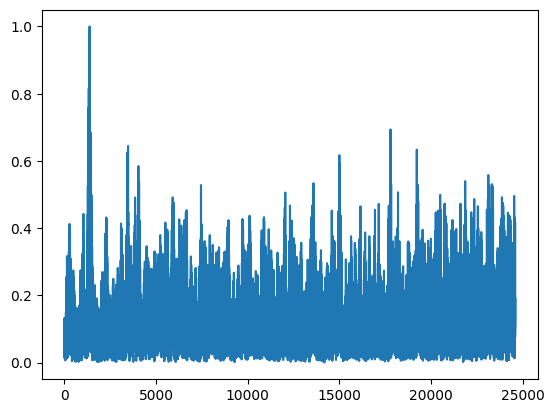

In [57]:
plt.figure()
plt.plot(abs(fft_tensor[0:128*64*3])/abs(fft_tensor).max())

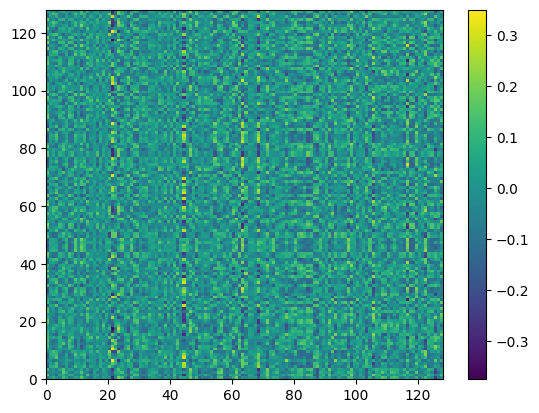

In [49]:
plt.figure()
plt.pcolormesh(dct_tensor[:,:,2])
plt.colorbar()

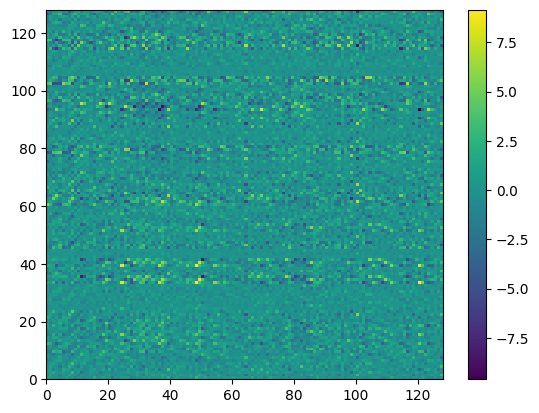

In [5]:
plot_tensor = tensor.reshape([3,128,128])
plt.figure()
plt.pcolormesh(plot_tensor[0])
plt.colorbar()

## Get tensor charateristics

In [6]:
actual_rank= calculate_cp_rank(tensor.numpy())
print("The acutal rank of the tensor is: ", actual_rank)

Testing rank: 1
Error:1.6581024
Testing rank: 2
Error:0.96949846
Testing rank: 3
Error:0.23950773
Testing rank: 4
Error:9.426466e-06
The acutal rank of the tensor is:  4


In [7]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.00103759765625


## Tensor compression

#### Jpeg

In [8]:
lowrank_jpeg_ratio = []
lowrank_jpeg_snr =[]
lowrank_jpeg_mse = []

In [9]:
for i in range(10):
    jpeg_quality = 55 + i *5
    normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor, jpeg_quality)
    print("Compressed size: ", compressed_size_jpeg)

    reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape,normalize_base, scale,zero_point, encoded_data )
    snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    print("Reconstruction snr (dB): ", snr_jpeg)
    print("Reconstruction mse: ", mse_jpeg)
    
    lowrank_jpeg_ratio.append((tensor_size*4) / compressed_size_jpeg)
    lowrank_jpeg_snr.append(snr_jpeg)
    lowrank_jpeg_mse.append(mse_jpeg / torch.max(tensor).item())

Compressed size:  3819
Reconstruction snr (dB):  0.8533860743045807
Reconstruction mse:  2.0609543
Compressed size:  4343
Reconstruction snr (dB):  1.0399921983480453
Reconstruction mse:  1.9742755
Compressed size:  5058
Reconstruction snr (dB):  1.2951016426086426
Reconstruction mse:  1.8616447
Compressed size:  6063
Reconstruction snr (dB):  1.665521115064621
Reconstruction mse:  1.709444
Compressed size:  7215
Reconstruction snr (dB):  2.1802814304828644
Reconstruction mse:  1.5183743
Compressed size:  8987
Reconstruction snr (dB):  3.050621747970581
Reconstruction mse:  1.2426386
Compressed size:  11329
Reconstruction snr (dB):  4.529337286949158
Reconstruction mse:  0.8840427
Compressed size:  14949
Reconstruction snr (dB):  7.12144136428833
Reconstruction mse:  0.4867017
Compressed size:  21614
Reconstruction snr (dB):  12.408109903335571
Reconstruction mse:  0.14407742
Compressed size:  43288
Reconstruction snr (dB):  26.70509099960327
Reconstruction mse:  0.005356708


#### Tensor decomposition

In [10]:
lowrank_decomposition_ratio =[]
lowrank_decomposition_snr = []
lowrank_decomposition_mse = []

In [11]:
for i in range(10):
    decom_rank = i +1
    factors, compressed_size_decomposition = compressor_decomposition(tensor, decom_rank)
    print("Compressed size: ", compressed_size_decomposition)
    reconstructed_tensor_decomposition = decompressor_decomposition(factors )
    snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition)
    mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition)
    print("Reconstruction snr (dB): ", snr_decomposition)
    print("Reconstruction mse: ", mse_decomposition)

    lowrank_decomposition_ratio.append((tensor_size*4) / compressed_size_decomposition)
    lowrank_decomposition_snr.append(snr_decomposition)
    lowrank_decomposition_mse.append(mse_decomposition / torch.max(tensor).item())

Compressed size:  1036
Reconstruction snr (dB):  1.7979563772678375
Reconstruction mse:  1.6581024
Compressed size:  2072
Reconstruction snr (dB):  4.128598570823669
Reconstruction mse:  0.96949846
Compressed size:  3108
Reconstruction snr (dB):  10.20087480545044
Reconstruction mse:  0.23950773
Compressed size:  4144
Reconstruction snr (dB):  60.847320556640625
Reconstruction mse:  2.0638356e-06
Compressed size:  5180
Reconstruction snr (dB):  70.34396171569824
Reconstruction mse:  2.3174532e-07
Compressed size:  6216
Reconstruction snr (dB):  65.04417896270752
Reconstruction mse:  7.8521595e-07
Compressed size:  7252
Reconstruction snr (dB):  79.92681503295898
Reconstruction mse:  2.5510886e-08
Compressed size:  8288
Reconstruction snr (dB):  55.40841579437256
Reconstruction mse:  7.220466e-06
Compressed size:  9324
Reconstruction snr (dB):  96.58689498901367
Reconstruction mse:  5.5044963e-10
Compressed size:  10360
Reconstruction snr (dB):  97.89640426635742
Reconstruction mse:  4.

#### Regression

In [12]:
lowrank_regression_ratio = []
lowrank_regression_snr = []
lowrank_regression_mse = []

In [13]:
for i in range(10):
    regression_rank = i+1
    factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor, regression_rank)
    print("Compressed size: ", compressed_size_regression)

    reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
    snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
    mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
    print("Reconstruction snr (dB): ", snr_regression)
    print("Reconstruction mse: ", mse_regression)

    lowrank_regression_ratio.append((tensor_size*4) / compressed_size_regression)
    lowrank_regression_snr.append(snr_regression)
    lowrank_regression_mse.append(mse_regression / torch.max(tensor).item())

Compressed size:  12800.0
Reconstruction snr (dB):  3.2876241207122803
Reconstruction mse:  1.1766425
Compressed size:  13312.0
Reconstruction snr (dB):  3.294360041618347
Reconstruction mse:  1.1748191
Compressed size:  13824.0
Reconstruction snr (dB):  3.3100861310958862
Reconstruction mse:  1.1705726
Compressed size:  14336.0
Reconstruction snr (dB):  3.332579731941223
Reconstruction mse:  1.1645255
Compressed size:  14848.0
Reconstruction snr (dB):  3.37740421295166
Reconstruction mse:  1.152568
Compressed size:  15360.0
Reconstruction snr (dB):  3.392725884914398
Reconstruction mse:  1.1485089
Compressed size:  15872.0
Reconstruction snr (dB):  3.3984702825546265
Reconstruction mse:  1.1469908
Compressed size:  16384.0
Reconstruction snr (dB):  3.403659164905548
Reconstruction mse:  1.1456213
Compressed size:  16896.0
Reconstruction snr (dB):  3.4214377403259277
Reconstruction mse:  1.140941
Compressed size:  17408.0
Reconstruction snr (dB):  3.4321194887161255
Reconstruction mse:

#### Sketch ML

In [14]:
lowrank_sketchml_ratio = []
lowrank_sketchml_snr = []
lowrank_sketchml_mse = []

In [15]:
for i in range (10):
    d = (i+1) * 0.1
    a = 13-i
    minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,d,a)
    print("Compressed size: ", compressed_size_sketchml)

    reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
    snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    print("Reconstruction snr (dB): ", snr_sketchml)
    print("Reconstruction mse: ", mse_sketchml)
    
    lowrank_sketchml_ratio.append((tensor_size*4) / compressed_size_sketchml)
    lowrank_sketchml_snr.append(snr_sketchml)
    lowrank_sketchml_mse.append( mse_sketchml / torch.max(tensor).item())

Compressed size:  64199
Reconstruction snr (dB):  0.7131920009851456
Reconstruction mse:  2.1285694
Compressed size:  111035
Reconstruction snr (dB):  3.7170708179473877
Reconstruction mse:  1.0658593
Compressed size:  148742
Reconstruction snr (dB):  6.488190293312073
Reconstruction mse:  0.56310314
Compressed size:  178359
Reconstruction snr (dB):  9.035276770591736
Reconstruction mse:  0.3132415
Compressed size:  199231
Reconstruction snr (dB):  11.228305101394653
Reconstruction mse:  0.18904991
Compressed size:  211370
Reconstruction snr (dB):  12.921953201293945
Reconstruction mse:  0.1280005
Compressed size:  214964
Reconstruction snr (dB):  13.656723499298096
Reconstruction mse:  0.108077325
Compressed size:  210191
Reconstruction snr (dB):  13.395051956176758
Reconstruction mse:  0.11478939
Compressed size:  196526
Reconstruction snr (dB):  13.283765316009521
Reconstruction mse:  0.11776886
Compressed size:  174458
Reconstruction snr (dB):  12.369168996810913
Reconstruction mse

# Plot

Text(0, 0.5, 'Reconstruction SNR [dB]')

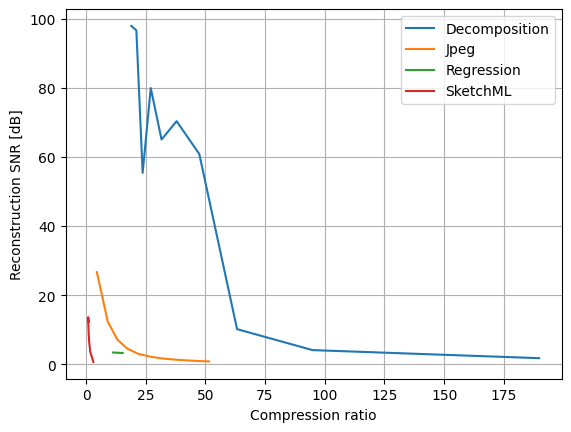

In [20]:
plt.figure()
plt.plot(lowrank_decomposition_ratio, lowrank_decomposition_snr,label ="Decomposition")
plt.plot(lowrank_jpeg_ratio, lowrank_jpeg_snr,label ="Jpeg")
plt.plot(lowrank_regression_ratio, lowrank_regression_snr,label ="Regression")
plt.plot(lowrank_sketchml_ratio, lowrank_sketchml_snr,label ="SketchML")
plt.legend()
plt.grid()
plt.xlabel("Compression ratio")
plt.ylabel("Reconstruction SNR [dB]")

# Plotting